In [4]:
import os
from enum import Enum
from math import floor
from dotenv import load_dotenv

import numpy as np
from tqdm.notebook import tqdm

import openai
from openai.embeddings_utils import get_embedding as get_embedding_openai, cosine_similarity

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from webdriver_manager.chrome import ChromeDriverManager

from bs4 import BeautifulSoup as bs, NavigableString, Comment

In [5]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [6]:
# Global Variables
TEXT_EMBEDDING_METHOD = 'ADA' # ['ADA', 'WORD2VEC', 'SPACY']
GRAPH_EMBEDDING_METHOD = 'NODE2VEC' # ['NODE2VEC', 'GCN']

In [7]:
chrome_options = Options()
# chrome_options.add_argument("--headless")
# chrome_options.add_argument("--window-size=3072x1920");

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

[WDM] - Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8.29M/8.29M [00:00<00:00, 9.53MB/s]


In [8]:
driver.get('https://ant.design/components/form')

In [9]:
def get_xpath(element):
    xpath_script = """
    function getPathTo(element) {
        // if (element.id !== '')
        //     return 'id(\"'+element.id+'\")';
        if (element === document.body)
            return element.tagName;
        var ix= 0;
        var siblings= element.parentNode.childNodes;
        for (var i= 0; i<siblings.length; i++) {
            var sibling= siblings[i];
            if (sibling===element)
                return getPathTo(element.parentNode) + '/' + element.tagName + '[' + (ix + 1) + ']';
            if (sibling.nodeType===1 && sibling.tagName===element.tagName)
                ix++;
        }
    }
    const path = getPathTo(arguments[0]);
    if (path.startsWith('id(')) {
        return path;
    }
    return '//' + path;
    """
    return driver.execute_script(xpath_script, element)


def get_visual_spans(element):
    # Get the location and size of the root element
    location = element.location
    size = element.size

    # Calculate the boundaries of the root element
    x_span = (location['x'], location['x'] + size['width'])
    y_span = (location['y'], location['y'] + size['height'])
    
    return x_span, y_span


def set_attribute(element, key, value):
    driver.execute_script("arguments[0].setAttribute(arguments[1], arguments[2])", element, key, value)


def embed_properties(root):
    '''
    This function embeds the x_span, y_span, and xpath
    properties into WebElement as attributes for processing
    in the next steps. We do this because we want to convert
    the WebElement into a BeautifulSoup document.
    '''
    x_span, y_span = get_visual_spans(root)
    xpath = get_xpath(root)
    
    set_attribute(root, 'xpath', xpath)
    set_attribute(root, 'x_start', x_span[0])
    set_attribute(root, 'x_end', x_span[1])
    set_attribute(root, 'y_start', y_span[0])
    set_attribute(root, 'y_end', y_span[1])
    
    for child in root.find_elements(By.XPATH, '*'):
        embed_properties(child)
    
    return root

In [10]:
form = driver.find_elements(By.TAG_NAME, 'form')[48]
# form = driver.find_element(By.ID, 'register')
form = embed_properties(form)

form_doc = bs(form.get_attribute('outerHTML'), 'html.parser')

# Get Processable Nodes

In [11]:
def is_displayed(element):
    if isinstance(element, NavigableString):
        return True
    
    x_start = float(element.attrs['x_start'])
    x_end = float(element.attrs['x_end'])
    y_start = float(element.attrs['y_start'])
    y_end = float(element.attrs['y_end'])
    
    return x_start != x_end and y_start != y_end


def should_skip_processing(element):
    should_skip = \
        isinstance(element, Comment) or \
        (isinstance(element, NavigableString) and element.strip() == '') or \
        not is_displayed(element)
    return should_skip


def is_force_not_keep(element):
    # TODO: list of elements not to keep, like children of svg
    return False


def is_force_keep(element):
    force_keep_tags = ['label', 'input', 'textarea', 'select', 'option', 'button']
    return element.name in force_keep_tags
    


def has_action_listener(element):
    # TODO: check if element has JavaScript action listeners
    # such as the case of <div> instead of <button> for submit
    return False


def is_processable(element):
    if not isinstance(element, NavigableString) and is_force_not_keep(element):
        return False
    
    if isinstance(element, NavigableString):
        if element.parent is not None and len(element.parent.contents) > 1:
            return True
    
    elif len(element.contents) == 0:
        return True
    
    elif len(element.contents) == 1 and isinstance(element.contents[0], NavigableString):
        return True
    
    elif is_force_keep(element):
        return True
    
    elif has_action_listener(element):
        return True
    
    return False
        


def get_processable_nodes(soup):
    nodes = []
    
    for element in soup.recursiveChildGenerator():
        if should_skip_processing(element):
            continue
        
        if is_processable(element):
            nodes.append(element)
    
    return nodes

In [12]:
form_processable_nodes = get_processable_nodes(form_doc)

# Create a Graph From Nodes

In [13]:
class EdgeDir(Enum):
    IN = 'IN'
    OUT = 'OUT'


class EdgeType(Enum):
    # connection via for attribute
    FOR = 'FOR'
    
    # neighbor connections
    CHILD = 'CHILD'
    # TODO: if no use, change all neighbour types to simple 'NEIGHBOUR'
    NLEFT = 'NLEFT'
    NRIGHT = 'NRIGHT'
    NTOP = 'NTOP'
    NBOTTOM = 'NBOTTOM'

In [14]:
class RelationGraph:
    def __init__(self):
        self._nodes = {}
        self._edges = {}
    
    
    def nodes(self):
        return list(self._nodes.values())
    
    
    def get_node(self, node_id):
        return self._nodes[node_id]
    
    
    def edges(self):
        return list(self._edges.values())
    
    
    def add_node(self, node):
        self._nodes[node.get_id()] = node
    
    
    def remove_node(self, node):
        self._nodes.pop(node.get_id())
    
    
    def add_edge(self, edge):
        source = edge.source
        target = edge.target
        
        source.add_edge(edge, EdgeDir.OUT)
        
        self._edges[edge.get_id()] = edge
    
    
    def remove_edge(self, edge):
        source = edge.source
        target = edge.target
        
        source.remove_edge(edge, EdgeDir.OUT)
        
        self._edges.pop(edge.get_id())
    
    
    def get_node_features(self):
        return {
            key: node.get_features() for key, node in self._nodes.items()
        }

In [15]:
def get_input_visible_text(element):
    text = ''
    attrs = element.attrs
    
    if 'placeholder' in attrs:
        text += f"{attrs['placeholder']} "
    if 'value' in attrs and attrs['value'].strip() != '':
        text += f", value is {attrs['value']} "
    if 'alt' in attrs:
        text += f", alt is {attrs['alt']} "
    
    text = text.strip().strip(', ')
    return text


def get_visible_text(element):
    if element.name == 'input' or \
        element.name == 'select' or \
        element.name == 'textarea':
        return get_input_visible_text(element)
    
    if element.string == None:
        return ''
    
    return str(element.string)


def get_null_embedding(dim=12288):
    return [0 for i in range(dim)]


def get_text_embedding(text, dim=12288):
    if text.strip() == '':
        return get_null_embedding(dim)
    
    if TEXT_EMBEDDING_METHOD == 'WORD2VEC':
        # TODO
        # average/something word2vec embeddings for each word
        pass
    elif TEXT_EMBEDDING_METHOD == 'SPACY':
        # TODO
        # https://spacy.io/usage/linguistic-features#vectors-similarity
        pass
    return get_embedding_openai(text.lower())


class RelationNode:
    def __init__(self, element):
        self.element = element
        
        self.xpath = self._find_xpath(element)
        self.x_span = self._find_span(element, 'x')
        self.y_span = self._find_span(element, 'y')
        
        self.visible_text = self._find_visible_text(element)
        self.features = self._calculate_features(self.visible_text)
        
        self.edges = {
            EdgeDir.OUT: {},
        }
        
        self.children_count = 0
    
    
    def _find_xpath(self, element):
        return element.attrs['xpath']
    
    
    def _find_span(self, element, axis):
        return (
            floor(float(element.attrs[f'{axis}_start'])),
            floor(float(element.attrs[f'{axis}_end']))
        )
    
    
    def _find_visible_text(self, element):
        return get_visible_text(element)
    
    
    def _calculate_features(self, visible_text):
        features = get_text_embedding(visible_text)
        return features
    
    
    def _change_children_count(self, edge, direction, increase=1):
        if edge.type == EdgeType.CHILD and direction == EdgeDir.OUT:
            self.children_count += increase
    
    
    def has_children(self):
        return self.children_count > 0
    
    
    def get_children(self):
        return list(filter(
            lambda x: x.type == EdgeType.CHILD,
            list(self.edges[EdgeDir.OUT].values())
        ))
    
    
    def add_edge(self, edge, direction):
        self.edges[direction][edge.get_id()] = edge
        self._change_children_count(edge, direction, 1)
    
    
    def remove_edge(self, edge, direction):
        self.edges[direction].pop(edge.get_id())
        self._change_children_count(edge, direction, -1)
    
    
    def get_visible_area(self):
        return (self.x_span[1] - self.x_span[0]) * (self.y_span[1] - self.y_span[0])
    
    
    def get_id(self):
        if 'id' in self.element.attrs:
            return self.element.attrs['id']
        return self.xpath
    
    
    def __repr__(self):
        return str(self)
   

    def __str__(self):
        return f'<{self.element.name}>{self.visible_text}</{self.element.name}> at y: {str(self.y_span)}, x: {str(self.x_span)}'


In [16]:
class RelationEdge:
    def __init__(self, source, target, conn_type):
        self.source = source
        self.target = target
        self.type = conn_type
        self.weight = 0
    
    
    def set_weight(self, weight):
        self.weight = weight
    
    
    def get_id(self):
        return f'edge {self.type.value} from {self.source} to {self.target}'
    
    
    def __repr__(self):
        return str(self)
    
    
    def __str__(self):
        return f'edge {self.type.value} weight {self.weight} from {self.source} to {self.target}'

In [17]:
def create_relations_graph(bs_doc):
    graph = RelationGraph()
    
    for n in tqdm(bs_doc):
        # TODO: add these strings to processing later
        # wrap a span around the text and process the span instead
        if isinstance(n, NavigableString):
            continue
        node = RelationNode(n)
        graph.add_node(node)

    return graph

In [18]:
relation_graph = create_relations_graph(form_processable_nodes)

  0%|          | 0/14 [00:00<?, ?it/s]

In [19]:
def get_text_similarity(node1, node2):
    embedding1 = node1.features
    embedding2 = node2.features
    try:
        sim = cosine_similarity(embedding1, embedding2)
        return 0 if np.isnan(sim) else sim
    except:
        return 0

In [20]:
relation_graph.nodes()

[<label>Username</label> at y: (8301, 8333), x: (459, 539),
 <input>Please input</input> at y: (8301, 8333), x: (539, 699),
 <a>Need Help?</a> at y: (8309, 8326), x: (707, 782),
 <label>Address</label> at y: (8357, 8389), x: (472, 539),
 <input></input> at y: (8358, 8388), x: (551, 736),
 <span>Select province</span> at y: (8358, 8388), x: (551, 736),
 <path></path> at y: (8370, 8376), x: (726, 736),
 <input>Input street</input> at y: (8357, 8389), x: (747, 860),
 <label>BirthDate</label> at y: (8413, 8445), x: (464, 539),
 <input>Input birth year</input> at y: (8413, 8445), x: (539, 731),
 <input>Input birth month</input> at y: (8413, 8445), x: (739, 931),
 <label> </label> at y: (8469, 8501), x: (529, 539),
 <button>Submit</button> at y: (8469, 8501), x: (539, 617),
 <span>Submit</span> at y: (8474, 8496), x: (555, 601)]

# Semantic Relationship Tests

In [21]:
labels = list(filter(lambda x: x.element.name == 'label', relation_graph.nodes()))
inputs = list(filter(
    lambda x: x.element.name == 'input' or \
                x.element.name == 'textarea' or \
                x.element.name == 'select',
    relation_graph.nodes()
))

In [22]:
labels

[<label>Username</label> at y: (8301, 8333), x: (459, 539),
 <label>Address</label> at y: (8357, 8389), x: (472, 539),
 <label>BirthDate</label> at y: (8413, 8445), x: (464, 539),
 <label> </label> at y: (8469, 8501), x: (529, 539)]

In [23]:
inputs

[<input>Please input</input> at y: (8301, 8333), x: (539, 699),
 <input></input> at y: (8358, 8388), x: (551, 736),
 <input>Input street</input> at y: (8357, 8389), x: (747, 860),
 <input>Input birth year</input> at y: (8413, 8445), x: (539, 731),
 <input>Input birth month</input> at y: (8413, 8445), x: (739, 931)]

## POS Tagging

In [24]:
import spacy
from spacy import displacy

%matplotlib inline

In [25]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("check-out")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

check check VERB VB compound xxxx True False
- - PUNCT HYPH punct - False False
out out NOUN NN ROOT xxx True True


## Keyword Extraction

In [26]:
# !pip3 install rake-nltk

In [27]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parsaalian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/parsaalian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
from rake_nltk import Rake

# Uses stopwords for english from NLTK, and all puntuation characters by default
r = Rake()

text = "Please input birth month"

# Extraction given the text.
r.extract_keywords_from_text(text)

# To get keyword phrases ranked highest to lowest.
keywords = r.get_ranked_phrases()

print(keywords)

['please input birth month']


## Embedding Search

In [29]:
hypernym_examples = [
    ('animal', 'mammal'),
    ('plant', 'flower'),
    ('red', 'scarlet')
]

hypernym_vector = sum([
    np.array(get_embedding_openai(t[0])) - np.array(get_embedding_openai(t[1])) for t in hypernym_examples
]) / len(hypernym_examples)

In [10]:
hypernym_vector

array([-4.49216471e-03, -1.78063948e-03,  4.75415650e-04, ...,
        1.02301175e-03, -2.95815477e-03, -8.57086852e-05])

In [11]:
cosine_similarity(
    np.array(get_embedding_openai('fruit')) - hypernym_vector,
    np.array(get_embedding_openai('apple'))
)

0.8508485824138341

In [12]:
cosine_similarity(
    np.array(get_embedding_openai('fruit')) - hypernym_vector,
    np.array(get_embedding_openai('orange'))
)

0.8413143005970661

In [13]:
cosine_similarity(
    np.array(get_embedding_openai('fruit')) - hypernym_vector,
    np.array(get_embedding_openai('motorcycle'))
)

0.7609944821999605

In [14]:
cosine_similarity(
    np.array(get_embedding_openai('vehicle')) - hypernym_vector,
    np.array(get_embedding_openai('motorcycle'))
)

0.8568304447943235

In [15]:
cosine_similarity(
    np.array(get_embedding_openai('vehicle')) - hypernym_vector,
    np.array(get_embedding_openai('apple'))
)

0.7552611790672324

In [16]:
# meronymy

In [17]:
meronym_examples = [
    ('tree', 'bark'),
    ('tree', 'branch'),
    ('arm', 'elbow'),
    ('computer', 'keyboard')
]

meronym_vector = sum([
    np.array(get_embedding_openai(t[0])) - np.array(get_embedding_openai(t[1])) for t in meronym_examples
]) / len(hypernym_examples)

In [18]:
cosine_similarity(
    np.array(get_embedding_openai('book')) - hypernym_vector,
    np.array(get_embedding_openai('page'))
)

0.7827630191574573

In [19]:
cosine_similarity(
    np.array(get_embedding_openai('flower')) - hypernym_vector,
    np.array(get_embedding_openai('petal'))
)

0.8800015100553241

In [20]:
cosine_similarity(
    np.array(get_embedding_openai('book')) - hypernym_vector,
    np.array(get_embedding_openai('petal'))
)

0.7953297001908752

In [21]:
cosine_similarity(
    np.array(get_embedding_openai('house')) - hypernym_vector,
    np.array(get_embedding_openai('door'))
)

0.8169333603490144

In [22]:
cosine_similarity(
    np.array(get_embedding_openai('house')) - hypernym_vector,
    np.array(get_embedding_openai('motorcycle'))
)

0.7825665215308527

In [23]:
cosine_similarity(
    np.array(get_embedding_openai('input birth year')) - hypernym_vector,
    np.array(get_embedding_openai('select birth month'))
)

0.8518611191995366

## WordNet

In [24]:
from nltk.corpus import wordnet as wn

def find_relations(word):
    # Synonyms and antonyms
    synonyms = []
    antonyms = []

    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
            if lemma.antonyms():
                antonyms.append(lemma.antonyms()[0].name())

    print('Synonyms of', word, ':\n', set(synonyms))
    print('Antonyms of', word, ':\n', set(antonyms))

    # Hypernyms and hyponyms
    synsets = wn.synsets(word)
    if synsets:
        hypernyms = synsets[0].hypernyms()
        print('Hypernyms of', word, ':\n', hypernyms)
        print('Hyponyms of', word, ':\n', synsets[0].hyponyms())

        # Coordinate terms
        if hypernyms:
            print('Coordinate terms of', word, ':')
            for hypernym in hypernyms[0].hyponyms():
                if hypernym != synsets[0]:  # exclude the original word
                    print(hypernym)
    else:
        print('No hypernyms, hyponyms, or coordinate terms found for', word)

# Test the function
find_relations('check-in')

Synonyms of check-in :
 {'check-in'}
Antonyms of check-in :
 set()
Hypernyms of check-in :
 [Synset('arrival.n.02')]
Hyponyms of check-in :
 []
Coordinate terms of check-in :
Synset('anchorage.n.05')
Synset('appearance.n.05')
Synset('docking.n.01')
Synset('entrance.n.03')
Synset('landing.n.03')
Synset('landing.n.04')
Synset('return.n.02')


## Reverse

In [25]:
cosine_similarity(
    get_embedding_openai('select'),
    get_embedding_openai('input')
)

0.8573628972501769

## Sense2Vec

In [28]:
# !pip3 install sense2vec

In [1]:
from sense2vec import Sense2Vec
import spacy

s2v = Sense2Vec().from_disk("./s2v_reddit_2019_lg")

nlp = spacy.load("en_core_web_sm")
s2v = nlp.add_pipe("sense2vec")
s2v.from_disk("./s2v_reddit_2019_lg")

In [3]:
doc = nlp("departure")
freq = doc[:]._.s2v_freq
vector = doc[:]._.s2v_vec
most_similar = doc[:]._.s2v_most_similar(10)
# [(('machine learning', 'NOUN'), 0.8986967),
#  (('computer vision', 'NOUN'), 0.8636297),
#  (('deep learning', 'NOUN'), 0.8573361)]
most_similar

[(('departing', 'VERB'), 0.7668),
 (('departures', 'NOUN'), 0.7288),
 (('depart', 'VERB'), 0.6636),
 (('departed', 'VERB'), 0.6541),
 (('arrival', 'NOUN'), 0.637),
 (('’s departure', 'NOUN'), 0.6284),
 (('leaving', 'NOUN'), 0.6171),
 (('departs', 'VERB'), 0.6135),
 (('initial departure', 'NOUN'), 0.6042),
 (('actual departure', 'NOUN'), 0.5948)]

In [16]:
freq

10874

# Apply a Method

In [30]:
import pandas as pd

In [50]:
mapping = {
    str(label): label.visible_text for label in inputs
}

In [51]:
mapping

{'<input>Please input</input> at y: (8301, 8333), x: (539, 699)': 'Please input',
 '<input></input> at y: (8358, 8388), x: (551, 736)': '',
 '<input>Input street</input> at y: (8357, 8389), x: (747, 860)': 'Input street',
 '<input>Input birth year</input> at y: (8413, 8445), x: (539, 731)': 'Input birth year',
 '<input>Input birth month</input> at y: (8413, 8445), x: (739, 931)': 'Input birth month'}

In [52]:
idx = list(filter(lambda x: x.strip() != '', mapping.values()))

In [53]:
df = pd.DataFrame(0, index=idx, columns=idx)

In [54]:
df

,Please input,Input street,Input birth year,Input birth month
Please input,0,0,0,0
Input street,0,0,0,0
Input birth year,0,0,0,0
Input birth month,0,0,0,0


In [55]:
df.columns

Index(['Please input', 'Input street', 'Input birth year',
       'Input birth month'],
      dtype='object')

In [66]:
embedding_cache = {}


def get_embedding_or_cache(word):
    if word in embedding_cache:
        return embedding_cache[word]
    e = get_embedding_openai(word)
    embedding_cache[word] = e
    return e


for label1 in df.index:
    for label2 in df.index:
        df.loc[label1, label2] = cosine_similarity(
            get_embedding_or_cache(label1),
            get_embedding_or_cache(label2)
        )

In [67]:
df

,Please input,Input street,Input birth year,Input birth month
Please input,1.000000,0.832018,0.791867,0.792111
Input street,0.832018,1.000000,0.798003,0.812260
Input birth year,0.791867,0.798003,1.000000,0.913557
Input birth month,0.792111,0.812260,0.913557,1.000000


In [68]:
# !pip3 install seaborn

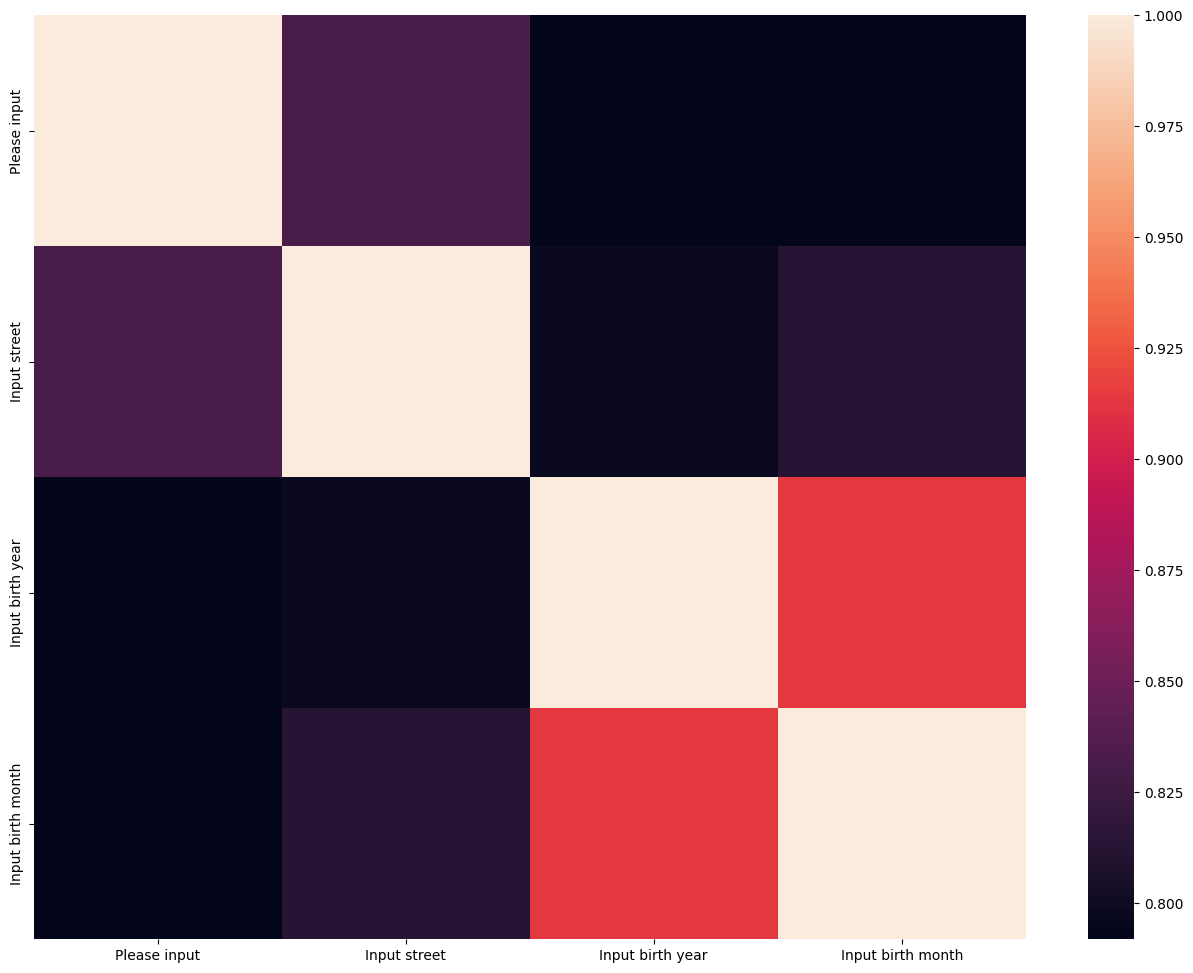

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# optional: resize images from now on
plt.rcParams["figure.figsize"] = (16, 12)

# numeric_only_columns is a list of columns of the DataFrame
# containing numerical data only
# annot = True to visualize the correlation factor

sns.heatmap(df, annot = False)
plt.show()

In [70]:
values = df.values

In [71]:
len(values)

4

In [72]:
sim_values = []

for i in range(len(values)):
    for j in range(len(values)):
        if i == j or j > i:
            continue
        sim_values.append(values[i, j])

<Axes: ylabel='Count'>

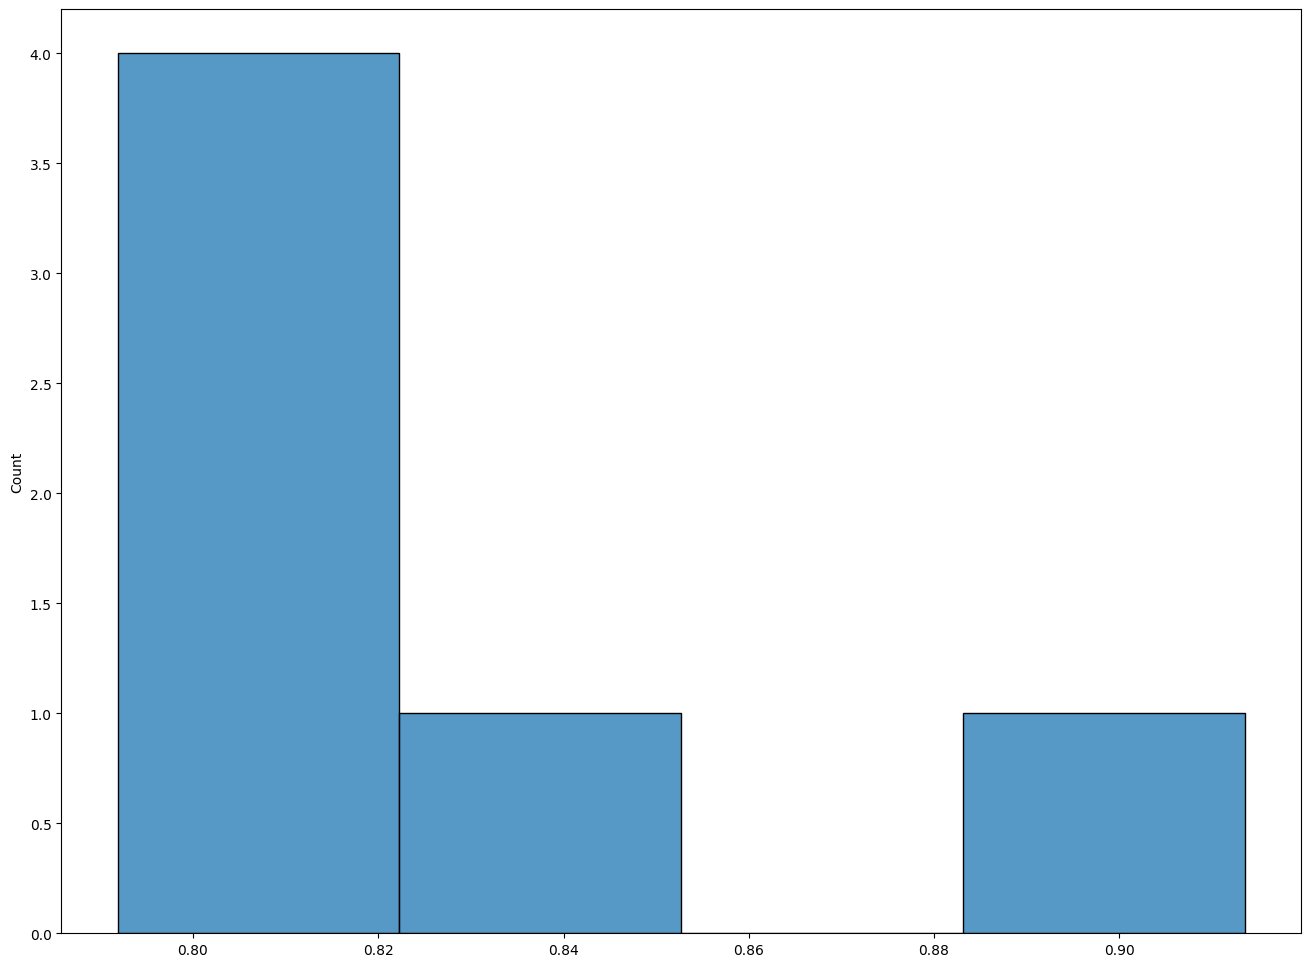

In [73]:
sns.histplot(sim_values)

In [74]:
mean = np.mean(sim_values)
std_dev = np.std(sim_values)

# Set the cutoff to be one standard deviation above the mean
cutoff = mean + std_dev

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Cutoff:", cutoff)

Mean: 0.8233025913109723
Standard Deviation: 0.04271023736332826
Cutoff: 0.8660128286743005


In [75]:
df[df < cutoff] = 0

In [76]:
df

,Please input,Input street,Input birth year,Input birth month
Please input,1.0,0.0,0.000000,0.000000
Input street,0.0,1.0,0.000000,0.000000
Input birth year,0.0,0.0,1.000000,0.913557
Input birth month,0.0,0.0,0.913557,1.000000
